In [1]:
import os

num_chains = 20
n_devices = min(os.cpu_count(), num_chains)
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={n_devices}'

from typing import Tuple, Dict, Any

import pandas as pd
import numpy as np
import jax.numpy as jnp
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from namgcv.basemodels.bnam import BayesianNAM
from namgcv.configs.bayesian_nam_config import DefaultBayesianNAMConfig
from namgcv.configs.bayesian_nn_config import DefaultBayesianNNConfig

import pickle

2025-03-11 12:19:51,112 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2025-03-11 12:19:51,114 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-03-11 12:19:51,114 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
2025-03-11 12:19:51,829 - datasets - INFO - PyTorch version 2.6.0 available.
2025-03-11 12:19:51,829 - datasets - INFO - JAX version 0.4.28 available.


In [2]:
GREEN_RGB_COLORS = [
    '#004c00',  # '#004e00', '#005000', '#005100', '#005300',
    # '#005500', # '#005700', '#005900', '#005a00', '#005c00',
    '#005e00',  # '#006000', '#006200', '#006300', '#006500',
    # '#006700', # '#006900', '#006b00', '#006c00', '#006e00',
    '#007000',  # '#007200', '#007400', '#007500', '#007700',
    # '#007900', # '#007b00', '#007d00', '#007e00', '#008000',
    '#008200',  # '#008400', '#008600', '#008800', '#008900',
    # '#008b00', # '#008d00', '#008f00', '#009100', '#009200',
    '#009400',  # '#009600', '#009800', '#009a00', '#009b00',
    # '#009d00', # '#009f00', '#00a100', '#00a300', '#00a400',
    '#00a600',  # '#00a800', '#00aa00', '#00ac00', '#00ad00',
    # '#00af00', # '#00b100', '#00b300', '#00b500', '#00b600',
    '#00b800',  # '#00ba00', '#00bc00', '#00be00', '#00bf00',
    # '#00c100', # '#00c300', '#00c500', '#00c700', '#00c800',
    '#00ca00',  # '#00cc00', '#00ce00', '#00d000', '#00d100',
    # '#00d300', # '#00d500', '#00d700', '#00d900', '#00da00',
    '#00dc00',  # '#00de00', '#00e000', '#00e200', '#00e300',
    # '#00e500', # '#00e700', '#00e900', '#00eb00', '#00ec00',
    '#00ee00',  # '#00f000', '#00f200', '#00f400', '#00f500',
    # '#00f700', # '#00f900', '#00fb00', '#00fd00', '#00ff00'
]

In [3]:
from matplotlib.colors import Normalize

def plot_synthetic_data_seaborn(df):
    """
    Plots the synthetic data (df with columns ['x1', 'x2', 'y']) using seaborn.
    Colors points by the continuous 'y' values with the built-in 'rocket' palette.
    Creates an explicit axes and figure, then attaches a colorbar without error.
    """
    # Normalize y to map its min/max to [0,1] for the colormap
    norm = Normalize(vmin=df['y'].min(), vmax=df['y'].max())
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(
        data=df,
        x='x1', y='x2',
        ax=ax,
        levels=10,
        color='green',
        alphas=0.1
    )
    sns.scatterplot(
        data=df,
        ax=ax,
        x='x1', y='x2', hue='y',
        palette='summer', hue_norm=norm, legend=False, alpha=1
    )

    # Create a ScalarMappable for the colorbar using the same palette and normalization.
    sm = plt.cm.ScalarMappable(cmap=sns.color_palette('summer', as_cmap=True), norm=norm)
    sm.set_array([])  # Needed in some matplotlib versions to avoid an error.
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("y")

    ax.set_title("Synthetic Data")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    plt.show()

In [4]:
def generate_synthetic_data(
    N=1000,
    cluster_centers=((2.0, -2.0), (-2.0, 2.0)),
    cluster_std=0.5,
    p_cluster=0.5,
    delta=0.5
):
    """
    Generate a synthetic dataset where:
      y = f1(x1) + f2(x2) + f12(x1, x2) + eps
    with:
      f1(x1)   = sin(x1)
      f2(x2)   = 0.1 * x2^3
      f12(x1,x2) = 0.2 * sin(x1 * x2)
    and eps ~ Mixture of N(+delta, sigma^2) and N(-delta, sigma^2).
    The variance sigma^2 depends on (x1,x2) via sigma = 0.1 + 0.05*(|x1|+|x2|).

    Returns:
        A pandas DataFrame with columns: ["x1", "x2", "y"].
    """

    # 1. Draw cluster assignments
    # cluster = 0 or 1 with probability p_cluster or (1-p_cluster)
    cluster_labels = np.random.choice([0,1], size=N, p=[p_cluster, 1-p_cluster])

    # 2. For each cluster, sample (x1, x2) from a 2D Gaussian
    #    with the given mean (cluster_centers[k]) and cluster_std in each dimension
    x1 = np.zeros(N)
    x2 = np.zeros(N)
    for k in [0,1]:
        idx = (cluster_labels == k)
        mean_k = cluster_centers[k]
        # We'll sample x1, x2 each from N(mean, cluster_std^2),
        # ignoring correlation within each cluster for simplicity.
        x1[idx] = np.random.normal(loc=mean_k[0], scale=cluster_std, size=idx.sum())
        x2[idx] = np.random.normal(loc=mean_k[1], scale=cluster_std, size=idx.sum())

    # 3. Define the true main effects and interaction
    def f1(x): return np.sin(x)
    def f2(x): return 0.1 * (x**3)
    def f12(x1, x2): return 0.2 * np.sin(x1 * x2)

    # 4. Compute the mean of y = f1(x1) + f2(x2) + f12(x1, x2)
    y_mean = f1(x1) + f2(x2) # + f12(x1, x2)

    # 5. Define heteroscedastic noise scale:
    #    sigma(x1,x2) = 0.1 + 0.05*(|x1| + |x2|)
    sigma = 0.1 + 0.05 * (np.abs(x1) + np.abs(x2))

    # 6. Sample noise eps from a mixture of two Gaussians: N(+delta, sigma^2) or N(-delta, sigma^2)
    #    each with probability 0.5
    mix_component = np.random.choice([0,1], size=N, p=[0.5, 0.5])
    eps = np.zeros(N)
    for i in range(N):
        mean_noise = +delta if mix_component[i] == 0 else -delta
        eps[i] = np.random.normal(loc=mean_noise, scale=sigma[i])

    # 7. Final y
    y = y_mean + eps

    # 8. Put into a DataFrame
    df = pd.DataFrame({"x1": x1, "x2": x2, "y": y, "sigma": sigma})
    return df

In [5]:
def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
):
    """
    Plots feature contributions for numerical, categorical, and interaction features.
    Now includes a separate heatmap panel for the uncertainty of interaction features.
    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features.
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features.
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of interaction features.
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names and values
            as numpy arrays of shape [num_samples, batch_size].
        target (jnp.ndarray):
            Target variable.
        aleatoric_uncertainty (Dict[str, jnp.ndarray]):
            Dictionary of aleatoric uncertainty estimates for each feature.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    # Plot numerical features
    if num_features:
        num_plots = len(num_features)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=2,
            figsize=(12, 6 * num_plots),
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(num_features.items()):

            feature_values = np.array(feature_array).flatten()  # Convert JAX array to NumPy

            # Shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]

            # [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)
            for j in [0, 1]:
                mean_param_contribution = mean_contribution_all_params[:, j]

                # Create vertical colored bars with color intensity based on density
                sorted_idx = np.argsort(feature_values)
                feature_values_sorted = feature_values[sorted_idx]

                mean_param_contribution_sorted = mean_param_contribution[sorted_idx]

                # Plot the centered partial contributions.
                sns.lineplot(
                    x=feature_values_sorted,
                    y=mean_param_contribution_sorted,
                    color=GREEN_RGB_COLORS[0],
                    label="Mean Output Parameter Contribution",
                    ax=ax[i, j]
                )

                uncertainty = np.std(submodel_contributions[feature_name][:, :, j], axis=0)[sorted_idx]
                ax[i,j].fill_between(
                    feature_values_sorted,
                    mean_param_contribution_sorted - 1.96 * uncertainty,
                    mean_param_contribution_sorted + 1.96 * uncertainty,
                    alpha=0.3,
                    color=GREEN_RGB_COLORS[-5],
                    label="Epistemic Uncertainty - 95% Interval"
                )

                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                norm_counts = counts / counts.max()
                fixed_height = ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0]
                for k in range(num_bins):
                    ax[i,j].bar(
                        bin_edges[k],
                        height=fixed_height,
                        bottom=ax[i,j].get_ylim()[0],
                        width=bin_edges[k + 1] - bin_edges[k],
                        color=plt.cm.Blues(norm_counts[k]),
                        alpha=0.3
                    )

                ax[i,j].set_xlabel(f"{feature_name}", fontsize=12)
                ax[i,j].set_ylabel("Feature Contribution", fontsize=12)
                ax[i,j].set_title(f"Feature Contribution for {feature_name}", fontsize=12)
                ax[i,j].legend(loc='best', fontsize=12, frameon=False)
                ax[i,j].grid(True)

        plt.tight_layout()
        plt.savefig('num_feature_contributions.png')
        plt.show()

In [6]:
np.random.seed(42)  # for reproducible example
df_data = generate_synthetic_data(N=1000)
# plot_synthetic_data_seaborn(df=df_data)
print(df_data.head(10))
print(f"\nDataset shape: {df_data.shape}")

         x1        x2         y     sigma
0  2.088851 -1.521649  0.783075  0.280525
1 -2.154605  1.509417 -1.171235  0.283201
2 -2.376078  1.767798  0.109070  0.307194
3 -1.840413  2.231030  0.322942  0.303572
4  1.332328 -2.392995  0.709621  0.286266
5  2.190099 -2.665616 -0.123409  0.342786
6  2.305293 -2.918103 -0.549112  0.361170
7 -1.329775  2.391695  0.547166  0.286074
8 -2.937586  1.874231 -0.019957  0.340591
9 -1.942487  1.701245 -0.304345  0.282187

Dataset shape: (1000, 4)


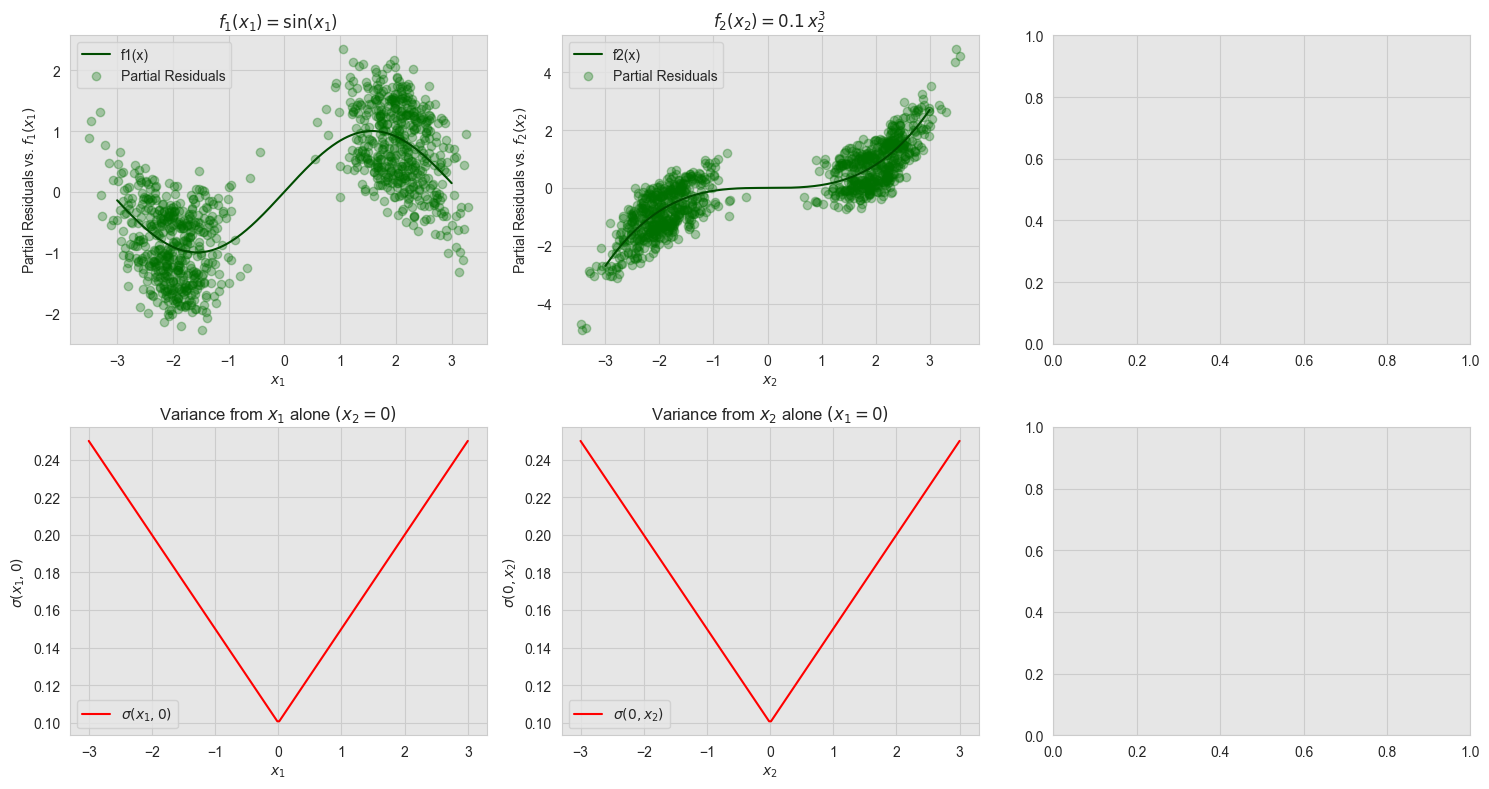

In [7]:
def plot_true_feature_contributions(df_data, x_min=-3, x_max=3, n_points=200):
    """
    Seaborn-style version of the extended plot function, in a 2x3 grid:
      1) f1(x) + partial residuals
      2) f2(x) + partial residuals
      3) f12(x1,x2) as a contour plot
      4) The variance from x1 alone (x2=0)
      5) The variance from x2 alone (x1=0)
      6) The full 2D contour of sigma(x1,x2).

    The synthetic data has:
        f1(x)   = sin(x)
        f2(x)   = 0.1 * x^3
        f12(x1,x2) = 0.2 * sin(x1 * x2)
    with heteroscedastic noise:
        sigma(x1,x2) = 0.1 + 0.05*(|x1| + |x2|).

    Parameters
    ----------
    df_data : pd.DataFrame
        Must contain ['x1', 'x2', 'y'] for the synthetic data.
    x_min : float
        Minimum x-value for plotting.
    x_max : float
        Maximum x-value for plotting.
    n_points : int
        Number of points in the linspace for plotting.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    df = df_data.copy()

    # Define the true functions
    def f1(x):
        return np.sin(x)
    def f2(x):
        return 0.1 * (x**3)
    def f12(x1, x2):
        return 0.2 * np.sin(x1 * x2)
    def sigma_true(x1, x2):
        return 0.1 + 0.05*(np.abs(x1) + np.abs(x2))

    # Partial residuals
    df['partial_y1'] = df['y'] - f2(df['x2']) - f12(df['x1'], df['x2'])
    df['partial_y2'] = df['y'] - f1(df['x1']) - f12(df['x1'], df['x2'])

    # Domain and mesh
    x = np.linspace(x_min, x_max, n_points)
    f1_values = f1(x)
    f2_values = f2(x)
    sigma_f1_1d = sigma_true(x, 0.0)
    sigma_f2_1d = sigma_true(0.0, x)

    X1, X2 = np.meshgrid(x, x)
    f12_values = f12(X1, X2)
    sigma_2d = sigma_true(X1, X2)

    # Create figure
    # We'll do 2 rows x 3 cols => total 6 subplots
    fig, axes = plt.subplots(
        nrows=2, ncols=3,
        figsize=(5*3, 4*2),  # width=15, height=8
        squeeze=False
    )
    ax_f1       = axes[0, 0]
    ax_f2       = axes[0, 1]
    # ax_f12      = axes[0, 2]
    ax_var_f1   = axes[1, 0]
    ax_var_f2   = axes[1, 1]
    # ax_var_2d   = axes[1, 2]

    # === Plot (0,0): f1(x) + partial residuals
    sns.lineplot(
        x=x, y=f1_values,
        ax=ax_f1,
        color=GREEN_RGB_COLORS[0],
        label='f1(x)'
    )
    ax_f1.scatter(
        df['x1'],
        df['partial_y1'],
        color=GREEN_RGB_COLORS[2],
        alpha=0.3,
        label='Partial Residuals'
    )
    ax_f1.set_title(r"$f_1(x_1) = \sin(x_1)$")
    ax_f1.set_xlabel("$x_1$")
    ax_f1.set_ylabel("Partial Residuals vs. $f_1(x_1)$")
    ax_f1.legend(loc='best')
    ax_f1.grid(True)

    # === Plot (0,1): f2(x) + partial residuals
    sns.lineplot(
        x=x, y=f2_values,
        ax=ax_f2,
        color=GREEN_RGB_COLORS[0],
        label='f2(x)'
    )
    ax_f2.scatter(
        df['x2'],
        df['partial_y2'],
        color=GREEN_RGB_COLORS[2],
        alpha=0.3,
        label='Partial Residuals'
    )
    ax_f2.set_title(r"$f_2(x_2) = 0.1\, x_2^3$")
    ax_f2.set_xlabel("$x_2$")
    ax_f2.set_ylabel("Partial Residuals vs. $f_2(x_2)$")
    ax_f2.legend(loc='best')
    ax_f2.grid(True)

    # === Plot (0,2): contour of f12 + data scatter
    # cntr = ax_f12.contourf(X1, X2, f12_values, levels=20, cmap='Greens')
    # fig.colorbar(cntr, ax=ax_f12, label=r"$f_{12}(x_1,x_2)$")
    # ax_f12.scatter(
    #     df['x1'],
    #     df['x2'],
    #     color=GREEN_RGB_COLORS[2],
    #     alpha=0.3,
    #     label='(x1, x2) data'
    # )
    # ax_f12.set_title(r"$f_{12}(x_1, x_2) = 0.2\,\sin(x_1 x_2)$")
    # ax_f12.set_xlabel("$x_1$")
    # ax_f12.set_ylabel("$x_2$")
    # ax_f12.legend(loc='best')
    # ax_f12.grid(True)

    # === Plot (1,0): variance from x1 alone => sigma(x1,0)
    var_f1_line = sigma_true(x, 0.0)
    sns.lineplot(
        x=x, y=var_f1_line,
        ax=ax_var_f1,
        color='red',
        label=r'$\sigma(x_1, 0)$'
    )
    ax_var_f1.set_title(r"Variance from $x_1$ alone $(x_2=0)$")
    ax_var_f1.set_xlabel("$x_1$")
    ax_var_f1.set_ylabel(r"$\sigma(x_1,0)$")
    ax_var_f1.legend(loc='best')
    ax_var_f1.grid(True)

    # === Plot (1,1): variance from x2 alone => sigma(0,x2)
    var_f2_line = sigma_true(0.0, x)
    sns.lineplot(
        x=x, y=var_f2_line,
        ax=ax_var_f2,
        color='red',
        label=r'$\sigma(0, x_2)$'
    )
    ax_var_f2.set_title(r"Variance from $x_2$ alone $(x_1=0)$")
    ax_var_f2.set_xlabel("$x_2$")
    ax_var_f2.set_ylabel(r"$\sigma(0,x_2)$")
    ax_var_f2.legend(loc='best')
    ax_var_f2.grid(True)

    # # === Plot (1,2): 2D contour of sigma
    # sigma_cntr = ax_var_2d.contourf(
    #     X1, X2, sigma_2d,
    #     levels=20, cmap='Reds'
    # )
    # fig.colorbar(sigma_cntr, ax=ax_var_2d, label=r"$\sigma(x_1,x_2)$")
    # ax_var_2d.scatter(
    #     df['x1'], df['x2'],
    #     color='red',
    #     alpha=0.3,
    #     label='(x1, x2) data'
    # )
    # ax_var_2d.set_title(r"Full variance: $\sigma(x_1,x_2)$")
    # ax_var_2d.set_xlabel("$x_1$")
    # ax_var_2d.set_ylabel("$x_2$")
    # ax_var_2d.legend(loc='best')
    # ax_var_2d.grid(True)

    plt.tight_layout()
    # Optionally: plt.savefig("true_feature_contributions_seaborn.png")
    plt.show()

plot_true_feature_contributions(df_data=df_data)

In [8]:
X = df_data.drop(columns=['y', 'sigma'])
y = df_data['y']
input_dim = X.shape[1]

In [9]:
import numpyro
numpyro.set_host_device_count(
    DefaultBayesianNAMConfig().num_chains
)
model = BayesianNAM(
    cat_feature_info={},
    num_feature_info={
        feature_name: {
            "input_dim": 1,
            "output_dim": 2
        } for feature_name in X.columns
    },
    num_classes=1,
    config=DefaultBayesianNAMConfig(),
    subnetwork_config=DefaultBayesianNNConfig()
)

model.train_model(
    num_features={
        feature_name: jnp.array(
            X.iloc[:, col_idx]
        ) for col_idx, feature_name in enumerate(X.columns)
    },
    cat_features={},
    target=jnp.array(y),
)

2025-03-11 12:19:53,463 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-11 12:19:53,463 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-11 12:19:53,613 - namgcv.basemodels.bnam - INFO - 
+---------------------------------------+
| Bayesian NAM successfully initialized.|
+---------------------------------------+

2025-03-11 12:19:53,613 - namgcv.basemodels.bnam - INFO - Numerical feature network: x1
Network architecture:
Layer 0: Linear(1 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 1: Linear(16 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 2: Linear(16 -> 8) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 3: Linear(8 -> 6) 

2025-03-11 12:19:53,613 - namgcv.basemodels.bnam - INFO - Numerical feature network: x2
Network architecture:
Layer 0: Linear(1 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 1: Linear(16 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [10]:
if model.config.num_mixture_components > 1:
    final_params, final_mixture_coeffs, submodel_contributions = model.predict()
    final_loc_1 = final_params[..., 0].mean(axis=0)
    final_loc_2 = final_params[..., 1].mean(axis=0)

    final_scale_1 = final_params[..., 3].mean(axis=0)
    final_scale_2 = final_params[..., 4].mean(axis=0)

    final_alpha_1 = final_mixture_coeffs[..., 0].mean(axis=0)
    final_alpha_2 = final_mixture_coeffs[..., 1].mean(axis=0)
else:
    final_params, _, submodel_contributions = model.predict()
    final_loc = final_params[..., 0].mean(axis=0)
    final_scale = final_params[..., 1].mean(axis=0)

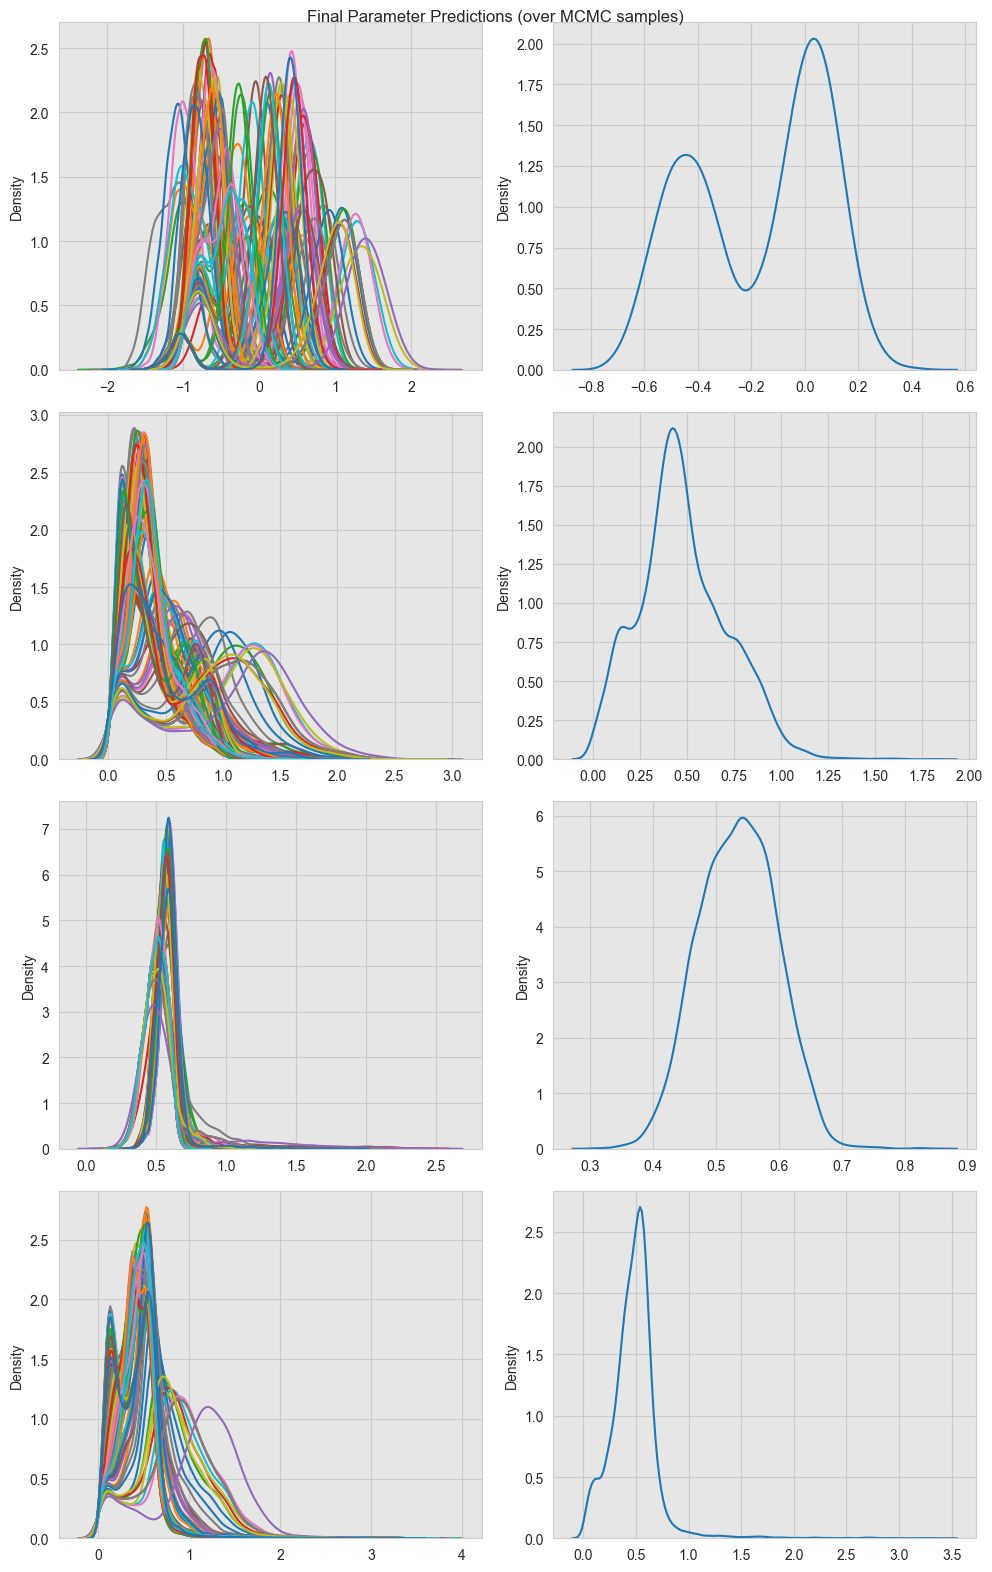

In [11]:
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
if model.config.num_mixture_components > 1:
    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(5*2, 4*4))
    for i, (final_param_name, final_param_pred) in enumerate(
            zip(
                ["loc_1", "loc_2", "scale_1", "scale_2",],
                [
                    final_params[..., 0],
                    final_params[..., 1],
                    final_params[..., 2],
                    final_params[..., 3],
                ]
            )
    ):
        for j in range(final_param_pred.shape[1]):
            sns.kdeplot(
                final_param_pred[:, j],
                ax=ax[i, 0]
            )
        sns.kdeplot(
            final_param_pred.mean(axis=1),
            ax=ax[i, 1],
            label=final_param_name
        )
        fig.suptitle(f"Final Parameter Predictions (over MCMC samples)", fontsize=12)
        ax[i, 0].grid(True)
        ax[i, 1].grid(True)

    plt.tight_layout()
    plt.show()
else:
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5*2, 4*2))
    for i, (final_param_name, final_param_pred) in enumerate(
            zip(
                ["loc", "scale"],
                [final_params[..., 0], final_params[..., 1]]
            )
    ):
        for j in range(final_param_pred.shape[1]):
            sns.kdeplot(
                final_param_pred[:, j],
                ax=ax[i, 0]
            )

        sns.kdeplot(
            final_param_pred.mean(axis=0),
            ax=ax[i, 1]
        )
        fig.suptitle(f"Final Parameter Predictions - {final_param_name.title()}", fontsize=12)
        ax[i, 0].grid(True)
        ax[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
):
    """
    Plots feature contributions for numerical, categorical, and interaction features,
    with line plots and density overlays for main features, and 2D tricontour for interactions.

    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features with shape (batch_size,).
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features (not specifically used here).
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of *2D* interaction features, each shaped (batch_size, 2),
            i.e. columns [x1, x2].
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names (e.g. 'x1', 'x2',
            or 'x1:x2') and values as numpy arrays of shape [num_mcmc_samples, batch_size, output_dim].
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})

    # ---------------------------
    # 1) Plot numeric features
    # ---------------------------
    if num_features:
        num_plots = len(num_features)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=2,
            figsize=(10, 4*num_plots),  # (width, height)
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(num_features.items()):
            # Convert JAX array to NumPy
            feature_values = np.array(feature_array).flatten()

            # shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]
            # shape: [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)

            for j in [0, 1]:
                sorted_idx = np.argsort(feature_values)
                x_sorted = feature_values[sorted_idx]
                y_sorted = mean_contribution_all_params[:, j][sorted_idx]

                # Plot mean line
                sns.lineplot(
                    x=x_sorted,
                    y=y_sorted,
                    color='blue',
                    label="Mean Contribution",
                    ax=ax[i, j]
                )

                # ±1.96 * std band
                param_samples = contributions[:, :, j]  # shape [num_mcmc_samples, batch_size]
                std_vals = np.std(param_samples, axis=0)[sorted_idx]
                y_lower = y_sorted - 1.96 * std_vals
                y_upper = y_sorted + 1.96 * std_vals
                ax[i,j].fill_between(
                    x_sorted,
                    y_lower,
                    y_upper,
                    alpha=0.3,
                    color='blue',
                    label="Epistemic ±1.96 std"
                )

                # Density overlay (vertical bars)
                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                if counts.max() > 0:
                    norm_counts = counts / counts.max()
                else:
                    norm_counts = counts
                y_min, y_max = ax[i,j].get_ylim()
                fixed_height = y_max - y_min
                for b in range(num_bins):
                    bin_left = bin_edges[b]
                    bin_right = bin_edges[b+1]
                    bin_width = bin_right - bin_left
                    val = norm_counts[b]
                    ax[i,j].bar(
                        bin_left,
                        fixed_height,
                        bottom=y_min,
                        width=bin_width,
                        color=plt.cm.Blues(val),
                        alpha=0.3,
                        linewidth=0
                    )

                ax[i,j].set_xlabel(feature_name, fontsize=12)
                ax[i,j].set_ylabel("Feature Contribution", fontsize=12)
                ax[i,j].set_title(f"Feature {feature_name}, param {j}", fontsize=12)
                ax[i,j].legend(loc='best', fontsize=10, frameon=False)
                ax[i,j].grid(True)

        plt.tight_layout()
        plt.savefig('num_feature_contributions.png')
        plt.show()

    # ---------------------------
    # 2) Plot interaction features
    # ---------------------------
    if interaction_features:
        num_interactions = len(interaction_features)
        fig, ax_int = plt.subplots(
            nrows=num_interactions, ncols=2,
            figsize=(5*2, 4*num_interactions),
            squeeze=False
        )
        for i, (interaction_name, interaction_array) in enumerate(interaction_features.items()):
            # shape: [batch_size, 2]
            X1 = np.array(interaction_array[:, 0])
            X2 = np.array(interaction_array[:, 1])

            # shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[interaction_name]
            # shape: [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)

            for j in [0, 1]:
                # Select a *single* Axes object from the 2D array:
                ax_ij = ax_int[i, j]

                # 1D array of Z-values for the interaction contribution
                Zvals = mean_contribution_all_params[:, j]

                # Plot with tricontourf, since we have scattered (X1, X2)
                ctf = ax_ij.tricontourf(X1, X2, Zvals, levels=20, cmap='Greens')
                fig.colorbar(ctf, ax=ax_ij, label="Mean Interaction Contribution")

                # Optionally scatter the points to show data coverage
                ax_ij.scatter(X1, X2, color='k', alpha=0.3, s=10, label='(x1,x2) data')

                ax_ij.set_xlabel("x1", fontsize=12)
                ax_ij.set_ylabel("x2", fontsize=12)
                ax_ij.set_title(f"Interaction: {interaction_name}, param {j}", fontsize=12)
                ax_ij.legend(loc='best', fontsize=10, frameon=False)
                ax_ij.grid(True)

        plt.tight_layout()
        plt.savefig('interaction_feature_contributions.png')
        plt.show()

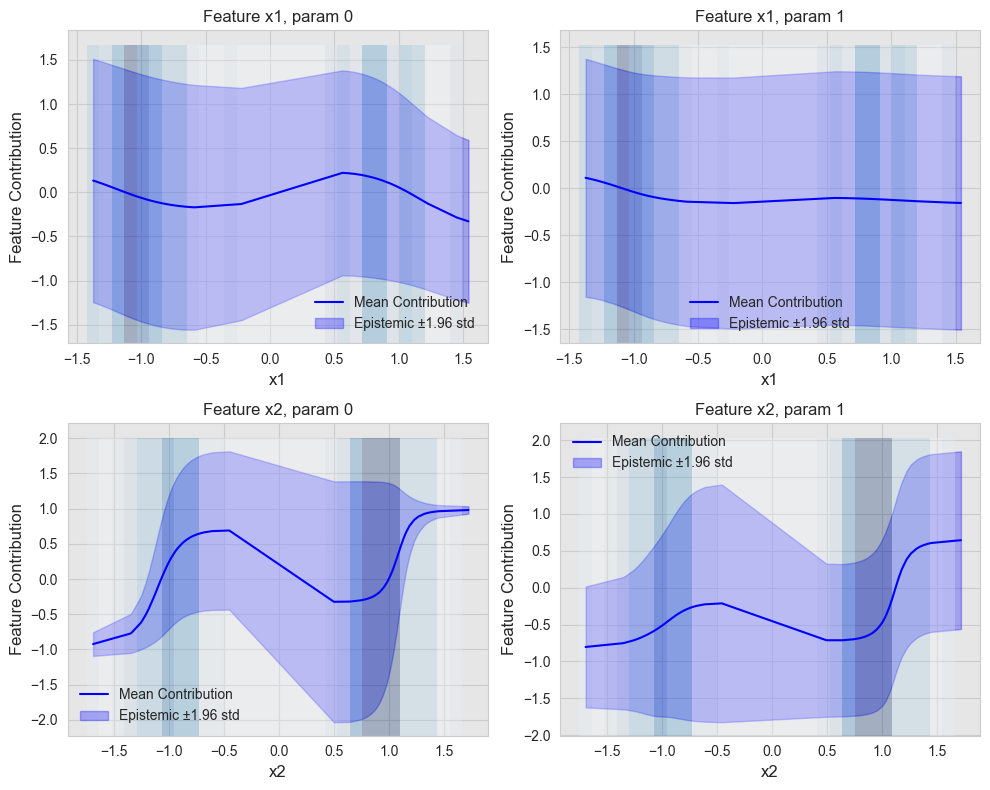

In [13]:
num_features = model.data_loader.data_test["numerical"]
cat_features = model.data_loader.data_test["categorical"]
interaction_feature_information = {}
all_features = {**num_features, **cat_features}
for interaction_name in submodel_contributions.keys():
    if ":" not in interaction_name:
        continue
    feature_names = interaction_name.split(":")
    interaction_feature_information[interaction_name] = jnp.concatenate(
        [jnp.expand_dims(all_features[name], axis=-1) for name in feature_names],
        axis=-1
    )

plot_feature_contributions(
    num_features=num_features,
    cat_features=cat_features,
    interaction_features=interaction_feature_information,
    submodel_contributions=submodel_contributions
)

C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_23652\2410139293.py:32: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


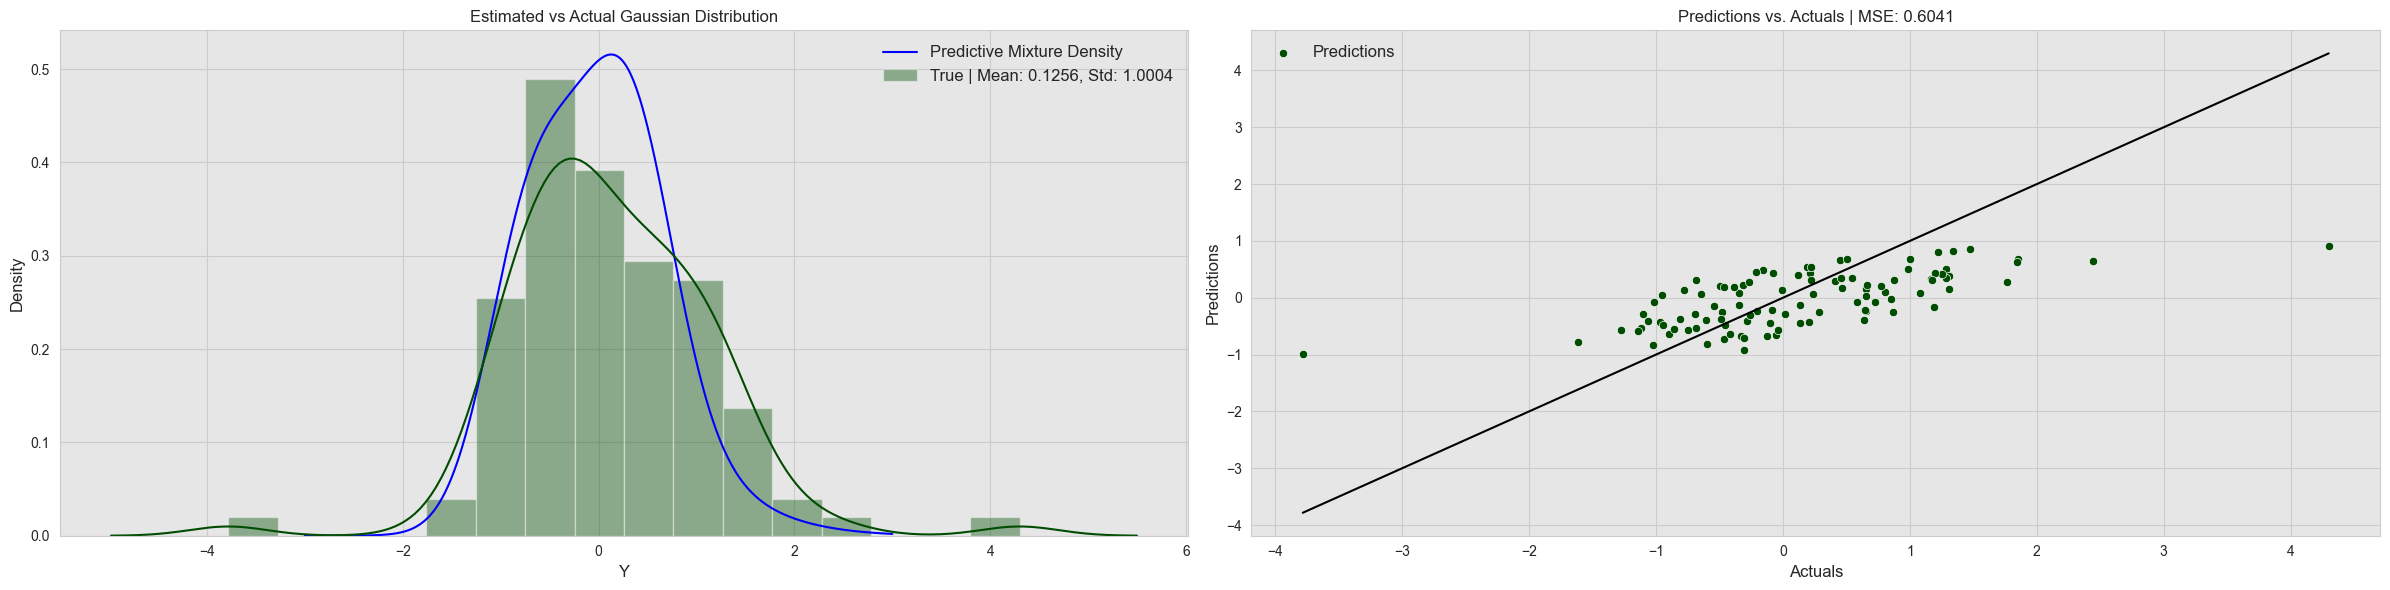

In [14]:
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12*2, 6))
x = np.linspace(-3, 3, 1000)
y_test = next(model.data_loader.iter(split="test", batch_size=None))["target"]

if model.config.num_mixture_components > 1:
    N = len(y_test)
    density = np.zeros_like(x)
    for i in range(N):
        # Mixture density for the i-th prediction:
        density_i = final_alpha_1[i] * norm.pdf(x, final_loc_1[i], final_scale_1[i]) + \
                    final_alpha_2[i] * norm.pdf(x, final_loc_2[i], final_scale_2[i])
        density += density_i

    density /= N  # Average density

    sns.lineplot(x=x, y=density, label="Predictive Mixture Density", color='blue', ax=ax[0])
    final_loc = final_alpha_1*final_loc_1+final_alpha_2*final_loc_2
else:
    ax[0].plot(
        x,
        norm.pdf(
            x,
            loc=final_loc.mean(),
            scale=final_scale.mean()
        ),
        label=f"Estimated | "
              f"Mean: {final_loc.mean():.4f}, "
              f"Std: {final_scale.mean():.4f}",
    )

sns.distplot(
    y_test,
    color=GREEN_RGB_COLORS[0],
    label=f"True | "
          f"Mean: {y_test.mean():.4f}, "
          f"Std: {y_test.std():.4f}",
    ax=ax[0],
    hist=True
)
ax[0].set_title("Estimated vs Actual Gaussian Distribution", fontsize=12)
ax[0].set_xlabel("Y", fontsize=12)
ax[0].set_ylabel("Density", fontsize=12)
ax[0].legend(loc='best', fontsize=12, frameon=False)
ax[0].grid(True)

# Plot the predictions vs. actuals.
# Plot the y=x line dotted.
sns.lineplot(
    x=y_test,
    y=y_test,
    color="black",
)
sns.scatterplot(
    x=y_test,
    y=final_loc,
    color=GREEN_RGB_COLORS[0],
    label="Predictions",
    ax=ax[1]
)
ax[1].set_xlabel("Actuals", fontsize=12)
ax[1].set_ylabel("Predictions", fontsize=12)
ax[1].set_title(
    f"Predictions vs. Actuals | "
    f"MSE: {np.mean((y_test - final_loc) ** 2):.4f}",
    fontsize=12
)
ax[1].legend(loc='best', fontsize=12, frameon=False)
ax[1].grid(True)

plt.tight_layout()
plt.show()

C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_21960\2828560822.py:52: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.array(samples_array), bins=30, ax=ax_to_plot)
C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_21960\2828560822.py:52: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n

KeyboardInterrupt: 

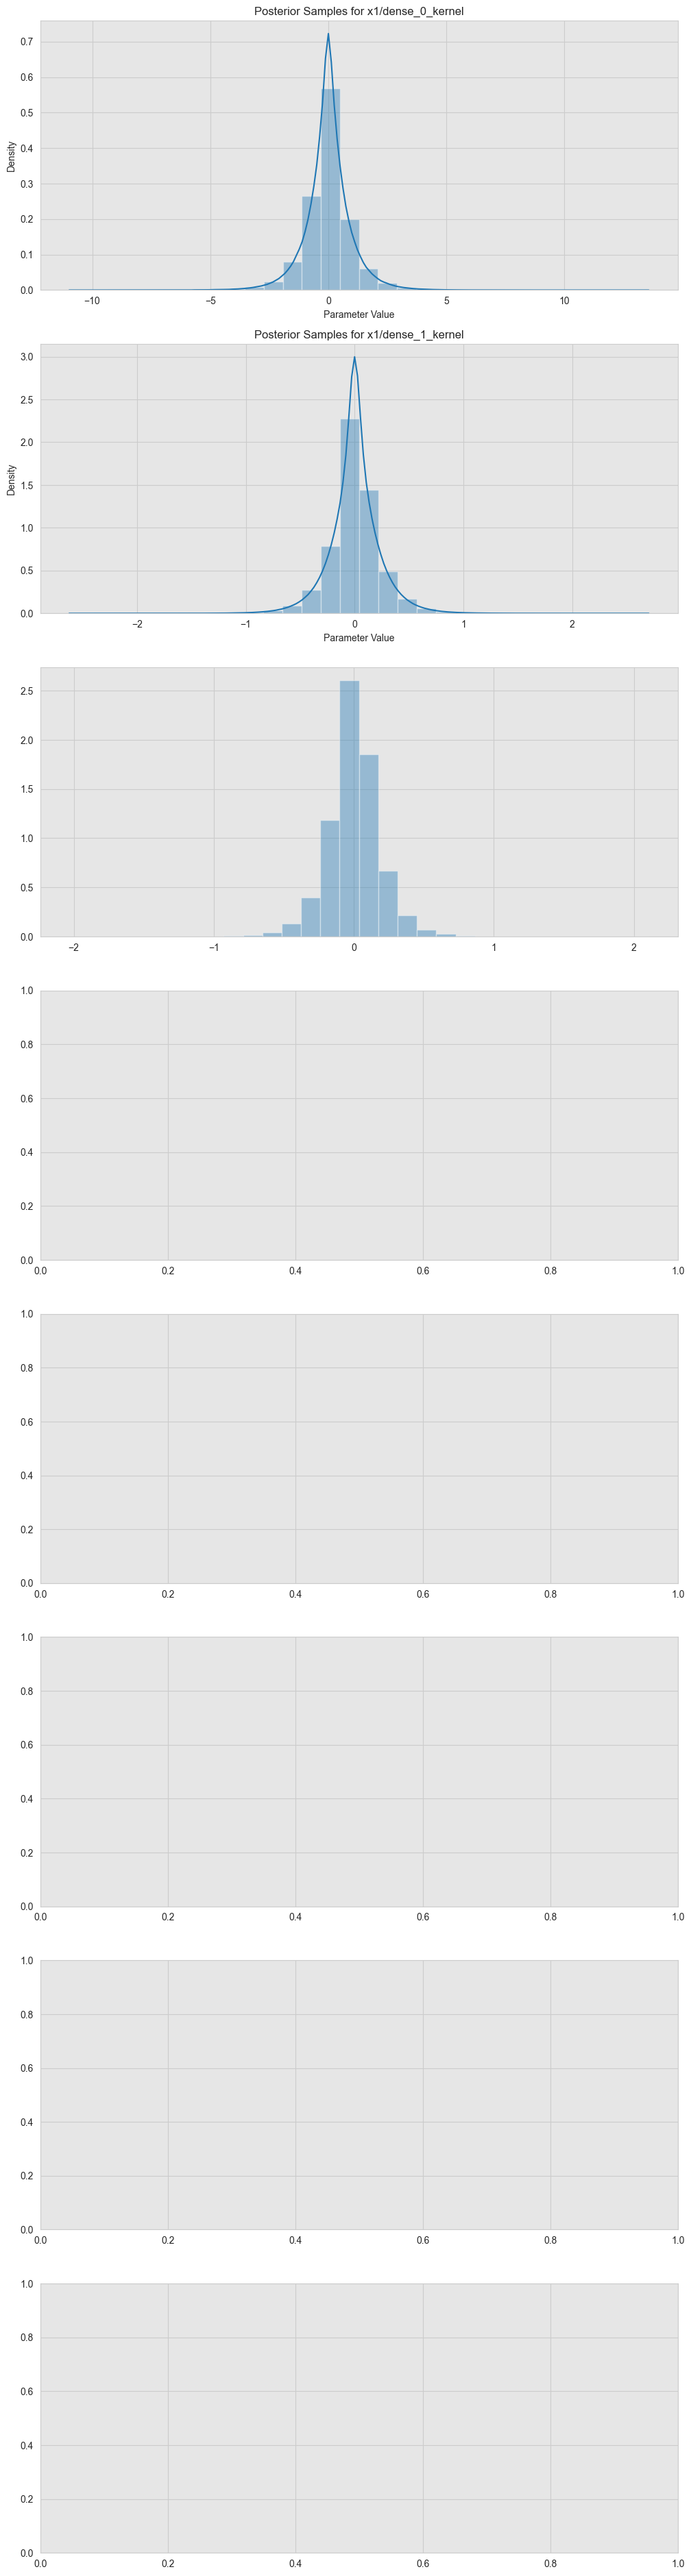

In [15]:
posterior_samples = model._mcmc.get_samples()

scale_params = {
    param_name: param_vals for param_name, param_vals in posterior_samples.items()
    if "scale" in param_name
}
weight_params = {
    param_name: param_vals for param_name, param_vals in posterior_samples.items()
    if "_kernel" in param_name and "scale" not in param_name
}
bias_params = {
    param_name: param_vals for param_name, param_vals in posterior_samples.items()
    if "_bias" in param_name and "scale" not in param_name
}
noise_params = {
    param_name: param_vals for param_name, param_vals in posterior_samples.items()
    if "sigma" in param_name
}

intercept_params = {
    param_name: param_vals for param_name, param_vals in posterior_samples.items()
    if "intercept" in param_name
} if model.config.intercept else None

posterior_param_samples_dict = {
    "noise": noise_params,
    "scale": scale_params,
    "kernels": weight_params,
    "biases": bias_params,
    "intercept": intercept_params
}

sns.set_style("whitegrid", {"axes.facecolor": ".9"})
for posterior_params_name, posterior_param_samples in posterior_param_samples_dict.items():
    if not posterior_param_samples:
        continue  # Intercept may be None.

    if posterior_params_name != "kernels":
        continue

    fig, ax = plt.subplots(
        nrows=len(posterior_param_samples),
        ncols=1,
        figsize=(12, 6*len(posterior_param_samples))
    )
    for i, (param_name, samples_array) in enumerate(posterior_param_samples.items()):
        # samples_array will be shape [num_mcmc_samples, ...]
        mean_val = jnp.mean(samples_array)
        std_val = jnp.std(samples_array)

        ax_to_plot = ax[i] if len(posterior_param_samples) > 1 else ax
        sns.distplot(np.array(samples_array), bins=30, ax=ax_to_plot)
        ax_to_plot.set_title(f"Posterior Samples for {param_name}")
        ax_to_plot.set_xlabel("Parameter Value")
        ax_to_plot.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

In [16]:
# posterior_param_samples_dict = model._get_posterior_param_samples()
#
# sns.set_style("whitegrid", {"axes.facecolor": ".9"})
# for posterior_params_name, posterior_param_samples in posterior_param_samples_dict.items():
#     if not posterior_param_samples:
#         continue  # Intercept may be None.
#
#     if "weight" not in posterior_params_name:
#         continue  # Only care about weights.
#
#     feature_names = list({
#         key.split("/")[0] for key in posterior_param_samples.keys()
#     })
#     for feature_name in feature_names:
#         param_names = [
#             key for key in posterior_param_samples.keys()
#             if feature_name in key
#         ]  # Parameters for this feature.
#         for i, param_name in enumerate(param_names):
#             if "w2" not in param_name:
#                 continue  # Let's only look at the last layer.
#             if "scale" in param_name:
#                 continue  # Not interested in the hierarchical prior.
#
#             # Convert the posterior samples into a DataFrame for easier plotting.
#             num_samples, num_layer_weights, num_outputs = posterior_param_samples[param_name].shape
#             samples_reshaped = posterior_param_samples[param_name].reshape(
#                 num_samples,
#                 num_layer_weights * num_outputs
#             )
#             column_names = [
#                 f"w2_{i}_output{j}" for j in range(num_outputs) for i in range(num_layer_weights)
#             ]
#             samples_df = pd.DataFrame(samples_reshaped, columns=column_names)
#
#             # Create the plot of bivariate marginals for the last layer weights.
#             for j in range(num_outputs):
#                 for i in range(num_layer_weights - 1):
#                     sns.jointplot(
#                         x=f"w2_{i}_output{j}",
#                         y=f"w2_{i + 1}_output{j}",
#                         data=samples_df,
#                         kind="kde",
#                         alpha=0.5,
#                         color=GREEN_RGB_COLORS[0]
#                     ).plot_joint(sns.kdeplot, color=GREEN_RGB_COLORS[0], alpha=0.3)
#             plt.show()